<a href="https://colab.research.google.com/github/vinodvicki/Yes_Bank/blob/main/Yes_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets /yes_bank Data set regression /data_YesBank_StockPrices.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [8]:
df.describe(include='all')

,Date,Open,High,Low,Close
count,185,185.000000,185.000000,185.000000,185.000000
unique,185,NaN,NaN,NaN,NaN
top,Nov-20,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,105.541405,116.104324,94.947838,105.204703
std,NaN,98.879850,106.333497,91.219415,98.583153
min,NaN,10.000000,11.240000,5.550000,9.980000
25%,NaN,33.800000,36.140000,28.510000,33.450000
50%,NaN,62.980000,72.550000,58.000000,62.540000
75%,NaN,153.000000,169.190000,138.350000,153.300000


In [9]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


In [10]:
df.duplicated().sum()

0

In [13]:
df['Date'] = pd.to_datetime(df['Date'], format= '%b-%y')
missing_date = df[df['Date'].isnull()]
missing_date

,Date,Open,High,Low,Close


In [14]:
df.head()

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


Exploring the data Analyis

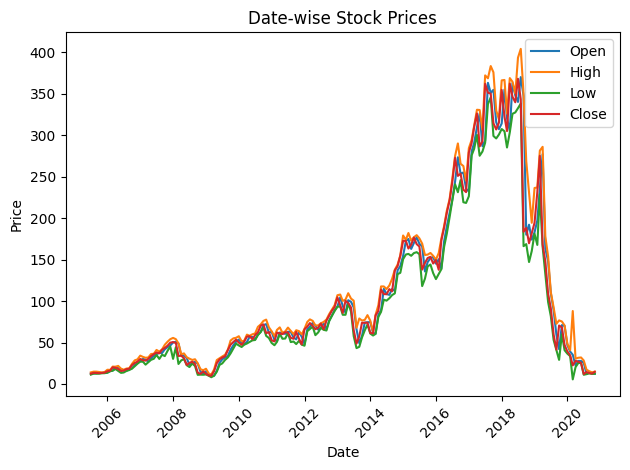

In [15]:
# prompt: plot the date wise operation on every column

for col in df.columns[1:]:
  plt.plot(df['Date'], df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Date-wise Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
df.corr().style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close
Date,1.000000,0.623355,0.637128,0.597551,0.606019
Open,0.623355,1.000000,0.993040,0.983978,0.977971
High,0.637128,0.993040,1.000000,0.983422,0.985051
Low,0.597551,0.983978,0.983422,1.000000,0.995358
Close,0.606019,0.977971,0.985051,0.995358,1.000000


The correlation matrix shows very high correlations among the stock price features:

- Open vs. High: 0.993
- Open vs. Low: 0.984
- Open vs. Close: 0.978
- High vs. Low: 0.983
- High vs. Close: 0.985
- Low vs. Close: 0.995

{'whiskers': [<matplotlib.lines.Line2D at 0x7a432b3165c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a432b3162c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a432b316f50>,
 'medians': [<matplotlib.lines.Line2D at 0x7a432b317940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7a432b317df0>,
 'means': []}

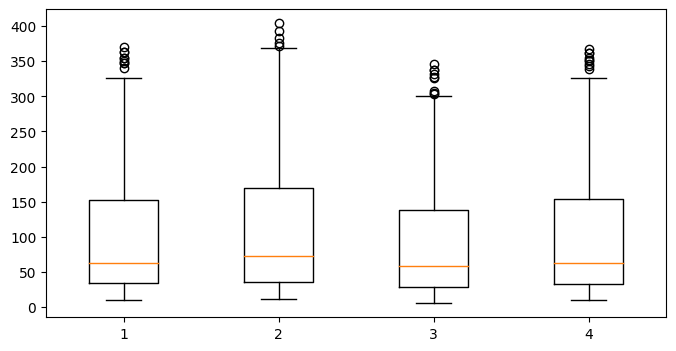

In [29]:
plt.figure(figsize=(8, 4))
plt.boxplot([df['Open'], df['High'], df['Low'], df['Close']])

In [20]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 12.9 MB/s eta 0:00:00


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
vif = variance_inflation_factor
df1 = df.iloc[:,1:]
vif_data = pd.DataFrame()
vif_data['feature'] = df1.columns
vif_data['VIF'] = [vif(df1.values, i) for i in range(df1.shape[1])]
vif_data

,feature,VIF
0,Open,288.504853
1,High,323.952468
2,Low,424.612257
3,Close,428.401649


Feature Engineering

To handle multicollinearity and enhance the model, we can create additional features such as moving averages, monthly returns, and volatility.

- Feature Engineering Steps:
- Moving Averages: Compute short-term and long-term moving averages for the closing prices.
- Monthly Returns: Calculate the percentage change in closing prices month over month.
- Volatility: Measure the standard deviation of the closing prices over a rolling window.